# CALIBRATION-MACHINE LEARNING

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import estim_param_toolbox as EPT
import sys
from matplotlib.pyplot import figure
from itertools import product
from math import *
from scipy.stats import norm
from scipy import interpolate
import scipy.optimize as opt
from keras.utils.vis_utils import plot_model
import keras
from scipy.optimize import minimize

In [54]:
from deep_pricing import *

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout

In [4]:
option_strike = np.linspace(0.5, 10, 20)/1000
tenor_duration = [1,3,6,9,12,24,60,120,180,240]
tenor_duration = [item / 12 for item in tenor_duration ]
option_duration = [1,3,6,9,12,24,60,120,180,240] ##1,3,6,9,12,24,60,120,180,240, pareil pour les tenors
option_duration = [item / 12 for item in option_duration ]



nombre_strike=len(option_strike)
nombre_duration=len(tenor_duration)
nombre_parametre_ligne=200

data= pd.DataFrame(list(product(option_duration, option_strike, tenor_duration)), columns=['Maturite', 'Strike', 'Tenor'])
data=data.append([data]*nombre_parametre_ligne,ignore_index=True)
data.describe()

<ipython-input-4-2dcdfc2daf34>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=data.append([data]*nombre_parametre_ligne,ignore_index=True)


,Maturite,Strike,Tenor
count,402000.000000,402000.000000,402000.000000
mean,5.458333,0.005250,5.458333
std,6.767193,0.002883,6.767193
min,0.083333,0.000500,0.083333
25%,0.500000,0.002875,0.500000
50%,1.500000,0.005250,1.500000
75%,10.000000,0.007625,10.000000
max,20.000000,0.010000,20.000000


In [5]:
n = len(data)
range_inf_sigma = 0.05
range_sup_sigma = 1

range_inf_mu = 0
range_sup_mu = 5

range_inf_lambda = 10**(-3)
range_sup_lambda = 3

grille_param=data
 
mean=[0,0,0]
cov=[[1,0,0],[0,1,0],[0,0,1]]
grille_param["Sigma"] , grille_param["Lambda"], grille_param["Mu"] = np.random.multivariate_normal(mean, cov, n).T

In [6]:
grille_param["Sigma"] = ( grille_param["Sigma"] * np.sqrt(0.00001) ) + 0.002
grille_param["Lambda"] = ( grille_param["Lambda"] * np.sqrt(0.01) ) + 0.02
grille_param["Mu"] = ( grille_param["Mu"] * np.sqrt(0.001) ) + 0.0025

In [7]:
grille_param = grille_param[ (grille_param["Sigma"] > 0.0001) & (grille_param["Sigma"] < 0.01) & (grille_param["Lambda"] > 0.0001)& (grille_param["Lambda"] < 0.2)&(grille_param["Mu"] > -0.01)&(grille_param["Mu"] < 0.1)]
grille_param.reset_index(drop=True).head()
#grille_param["Sigma"] = grille_param.apply(lambda x:x.Sigma/100 , axis = 1)
#grille_param["Lambda"] = grille_param.apply(lambda x:x.Lambda , axis = 1)
#grille_param["Mu"] = grille_param.apply(lambda x:x.Mu/50 , axis = 1)


,Maturite,Strike,Tenor,Sigma,Lambda,Mu
0,0.083333,0.0005,0.50,0.006759,0.153709,0.029102
1,0.083333,0.0010,1.00,0.001018,0.069337,-0.001380
2,0.083333,0.0015,0.25,0.002073,0.114861,0.025233
3,0.083333,0.0015,0.75,0.000795,0.155675,0.010327
4,0.083333,0.0015,2.00,0.001680,0.028639,0.013480


In [8]:
grille_param.describe()

,Maturite,Strike,Tenor,Sigma,Lambda,Mu
count,102362.000000,102362.000000,102362.000000,102362.000000,102362.000000,102362.000000
mean,5.488694,0.005255,5.426496,0.003387,0.077529,0.020193
std,6.787806,0.002881,6.750656,0.002167,0.051364,0.021145
min,0.083333,0.000500,0.083333,0.000100,0.000101,-0.010000
25%,0.500000,0.003000,0.500000,0.001636,0.034443,0.003246
50%,2.000000,0.005500,1.000000,0.003081,0.070429,0.016545
75%,10.000000,0.008000,10.000000,0.004823,0.114582,0.033290
max,20.000000,0.010000,20.000000,0.009998,0.199994,0.099917


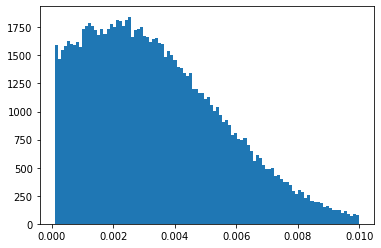

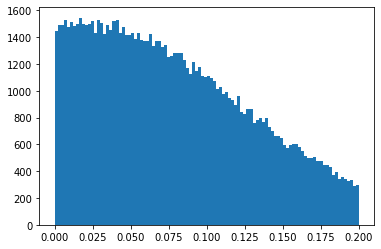

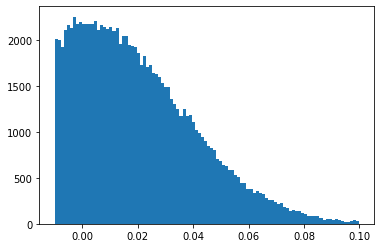

In [9]:
plt.figure(1)
plt.hist(grille_param["Sigma"], bins=100)
plt.figure(2)
plt.hist(grille_param["Lambda"], bins=100) 
plt.figure(3)
plt.hist(grille_param["Mu"], bins=100) 
plt.show()

# PRICING
notation
N = principal, on considère = 1 ici
K = strike
T_n = maturité+ tenor
T_0 = maturité
t = date de pricing = 0 ici
dt = 6M,
on price au 31/12/2019

I- Market price

In [10]:
#data_rates_ZC=pd.read_excel ("OIS_ZC_dec_2019.xlsx")
data_rates_ZC=pd.read_excel("data_2021.xlsx","OIS")

#ajouter Mid = (Bid+Ask)/2
data_rates_ZC["Mid"]=(data_rates_ZC["Final Bid Rate"]+data_rates_ZC["Final Ask Rate"])/200


#ajouter T (à partir de Term et Unit):
# Unit -> convertir DY à 1, convertir WK à 7, convertir MO à 30 et convertir yr 360
# T = Term * Unit /360 

## 1 mois = 1/12, 1 YR = 1
## 1 jour = 1/360
## 1 week = 7/360

#Bid = taux de vente 

data_rates_ZC["Unit_converti"] = data_rates_ZC.apply(lambda x: conversion_temps(x.Unit), axis = 1)
data_rates_ZC["T"]=(data_rates_ZC["Term"]*data_rates_ZC["Unit_converti"])/360


## -> un tableau avec T,ZC_rate

#add T colomn, add mean colomn, add Prix ZC_colomn 
data_rates_ZC.head()
new_rates_ZC=data_rates_ZC[["T", "Mid"]]
# add prix_ZC
new_rates_ZC["prix_ZC"]=0
new_rates_ZC.loc[0,"prix_ZC"]=np.exp(-new_rates_ZC.loc[0,"Mid"]*new_rates_ZC.loc[0,"T"])
for i in range(new_rates_ZC.shape[0]-1):
    new_rates_ZC.loc[i+1,"prix_ZC"]=np.exp(-new_rates_ZC.loc[i+1,"Mid"]*(new_rates_ZC.loc[i+1,"T"]-new_rates_ZC.loc[i,"T"]))*new_rates_ZC.loc[i,"prix_ZC"]
new_rates_ZC.head()

<ipython-input-10-393a6537c230>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_rates_ZC["prix_ZC"]=0
<ipython-input-10-393a6537c230>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_rates_ZC.loc[0,"prix_ZC"]=np.exp(-new_rates_ZC.loc[0,"Mid"]*new_rates_ZC.loc[0,"T"])


,T,Mid,prix_ZC
0,0.002778,-0.005050,1.000014
1,0.019444,-0.004902,1.000096
2,0.038889,-0.004903,1.000191
3,0.083333,-0.004906,1.000409
4,0.166667,-0.004895,1.000817


In [11]:
data_rates_ZC=pd.read_excel("data_2021.xlsx","OIS")

In [12]:
sigma_bachelier =pd.read_excel("data_20212.xlsx")
Valeur_tenor=sigma_bachelier.columns.tolist()[2:]
data_sigmabachelier = pd.melt(sigma_bachelier, id_vars=['Expir.',"Strike"], value_vars=Valeur_tenor)
data_sigmabachelier.columns = ['Maturite',"Strike","Tenor","Sigma"]
#data_sigma = data_sigma[data_sigma.Sigma!=' ']
data_sigmabachelier['Strike'] = data_sigmabachelier.loc[0,'Strike'] 

data_sigmabachelier['Unit']=data_sigmabachelier['Maturite'].apply(lambda x: x[-2:].upper())
data_sigmabachelier['Term']=data_sigmabachelier['Maturite'].apply(lambda x: int(x[:-2]))
data_sigmabachelier['Maturite'] =  data_sigmabachelier.apply(lambda x: conversion_temps(x.Unit), axis = 1)*data_sigmabachelier['Term']/360

data_sigmabachelier['Unit']=data_sigmabachelier['Tenor'].apply(lambda x: x[-2:].upper())
data_sigmabachelier['Term']=data_sigmabachelier['Tenor'].apply(lambda x: int(x[:-2]))
data_sigmabachelier['Tenor'] =  data_sigmabachelier.apply(lambda x: conversion_temps(x.Unit), axis = 1)*data_sigmabachelier['Term']/360

del data_sigmabachelier['Unit'],  data_sigmabachelier['Term']
data_sigmabachelier['Strike'] = data_sigmabachelier['Strike'] /1000
data_sigmabachelier

,Maturite,Strike,Tenor,Sigma
0,0.083333,0.0025,1.0,29.21
1,0.250000,0.0025,1.0,35.38
2,0.500000,0.0025,1.0,40.96
3,0.750000,0.0025,1.0,46.28
4,1.000000,0.0025,1.0,51.32
...,...,...,...,...
223,12.000000,0.0025,30.0,51.99
224,15.000000,0.0025,30.0,51.12
225,20.000000,0.0025,30.0,49.60
226,25.000000,0.0025,30.0,49.10


In [13]:
#PS_market(t,T_0,T_N,dt,K,data_sigma,data):
t = 0
T_0 = 30
T_N = 25
dt = 1/2
K = 0.0025
PS_market_bachelier(t,T_0,T_N,dt,K,data_sigmabachelier,new_rates_ZC)

0.02006828573520998

In [14]:
market_prices = data_sigmabachelier.apply(lambda x : PS_market_bachelier(t,x.Maturite, x.Tenor,dt,x.Strike/10000,data_sigmabachelier,new_rates_ZC), axis = 1)

In [15]:
sigma_excel=pd.read_excel ("data_2021.xlsx","Feuil1") 
sigma_excel.fillna(0)
sigma_excel["Strike "]=0.5
#sigma_excel

In [16]:
Valeur_maturite=sigma_excel["Expiry"].tolist()
#Valeur_strike=sigma_excel["Strike "].dropna().tolist()
Valeur_strike=[0.5]

Valeur_tenor=sigma_excel.columns.tolist()[1:-1]

In [17]:
#pd.melt(sigma_excel,)

#Valeur_tenor=sigma_excel.columns.tolist()[1:-1]
#data_sigma = pd.melt(sigma_excel, id_vars=['Expiry',"Strike "], value_vars=Valeur_tenor)
#data_sigma.columns = ['Maturite',"Strike","Tenor","Sigma"]
#data_sigma = data_sigma[data_sigma.Sigma!=' ']


#data_sigma['Unit']=data_sigma['Maturite'].apply(lambda x: x[-2:].upper())
#data_sigma['Term']=data_sigma['Maturite'].apply(lambda x: int(x[:-2]))
#data_sigma['Maturite'] =  data_sigma.apply(lambda x: conversion_temps(x.Unit), axis = 1)*data_sigma['Term']/360

#data_sigma['Unit']=data_sigma['Tenor'].apply(lambda x: x[-2:].upper())
#data_sigma['Term']=data_sigma['Tenor'].apply(lambda x: int(x[:-2]))
#data_sigma['Tenor'] =  data_sigma.apply(lambda x: conversion_temps(x.Unit), axis = 1)*data_sigma['Term']/360

#del data_sigma['Unit'],  data_sigma['Term']
#data_sigma
####Calcul et puis on supprime les Nans

# II- model price

In [18]:
print(ZC_model(10, 0, 0.01, 0.011, 0.002, 0.001))
print(prix_ZC_market(new_rates_ZC,0.001,10))
1.0082725902629155
1.0094655718619951
call_bond_price(1,0,1,10,0.025,0.005,0.0025,0)
#(T, t, a, sigma, r_bar, r)
0.07900245649719956
taux_fixe=-0.383/100 # valeur au 31/12/2019
grille_param["ZC_model_price"] = grille_param.apply(lambda x: ZC_model(x.Maturite,0,x.Lambda,x.Sigma,x.Mu,taux_fixe), axis = 1)
grille_param.describe()

1.0082725902629155
1.0094655718619951


<ipython-input-18-072c9b6951f9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grille_param["ZC_model_price"] = grille_param.apply(lambda x: ZC_model(x.Maturite,0,x.Lambda,x.Sigma,x.Mu,taux_fixe), axis = 1)


,Maturite,Strike,Tenor,Sigma,Lambda,Mu,ZC_model_price
count,102362.000000,102362.000000,102362.000000,102362.000000,102362.000000,102362.000000,102362.000000
mean,5.488694,0.005255,5.426496,0.003387,0.077529,0.020193,0.983326
std,6.787806,0.002881,6.750656,0.002167,0.051364,0.021145,0.080512
min,0.083333,0.000500,0.083333,0.000100,0.000101,-0.010000,0.260526
25%,0.500000,0.003000,0.500000,0.001636,0.034443,0.003246,1.000308
50%,2.000000,0.005500,1.000000,0.003081,0.070429,0.016545,1.001735
75%,10.000000,0.008000,10.000000,0.004823,0.114582,0.033290,1.003978
max,20.000000,0.010000,20.000000,0.009998,0.199994,0.099917,1.201441


In [19]:
data_sigmabachelier

,Maturite,Strike,Tenor,Sigma
0,0.083333,0.0025,1.0,29.21
1,0.250000,0.0025,1.0,35.38
2,0.500000,0.0025,1.0,40.96
3,0.750000,0.0025,1.0,46.28
4,1.000000,0.0025,1.0,51.32
...,...,...,...,...
223,12.000000,0.0025,30.0,51.99
224,15.000000,0.0025,30.0,51.12
225,20.000000,0.0025,30.0,49.60
226,25.000000,0.0025,30.0,49.10


In [20]:
grille_market=pd.DataFrame(columns={"Maturite", "ZC_market_price"})
grille_market["Maturite"]=grille_param["Maturite"].copy()
grille_market["Tenor"]=grille_param["Tenor"].copy()
grille_market["Strike"]=grille_param["Strike"].copy()



grille_market["ZC_market_price"]=grille_market.apply(lambda x: prix_ZC_market(new_rates_ZC,get_ZC_rate_market(new_rates_ZC,x.Maturite),x.Maturite), axis=1)

data_sigmabachelier["Swaption_market_price"] = data_sigmabachelier.apply(lambda x : PS_market_bachelier(t,x.Maturite, x.Tenor,dt,x.Strike/10000,data_sigmabachelier,new_rates_ZC), axis = 1)
#grille_market["ZC_market_price"]=grille_market.apply(lambda x: prix_ZC_market(new_rates_ZC,get_ZC_rate_market(new_rates_ZC,x.Maturite),x.Maturite), axis=1)
grille_market.describe()

,ZC_market_price,Maturite,Tenor,Strike
count,102362.000000,102362.000000,102362.000000,102362.000000
mean,1.000370,5.488694,5.426496,0.005255
std,0.011827,6.787806,6.750656,0.002881
min,0.968873,0.083333,0.083333,0.000500
25%,1.000409,0.500000,0.500000,0.003000
50%,1.003639,2.000000,1.000000,0.005500
75%,1.008323,10.000000,10.000000,0.008000
max,1.012610,20.000000,20.000000,0.010000


In [21]:
data_sigmabachelier["Swaption_market_price"] = data_sigmabachelier.apply(lambda x : PS_market_bachelier(t,x.Maturite, x.Tenor,dt,x.Strike/10000,data_sigmabachelier,new_rates_ZC), axis = 1)

data_sigmabachelier.describe()

,Maturite,Strike,Tenor,Sigma,Swaption_market_price
count,228.000000,2.280000e+02,228.000000,228.00000,228.000000
mean,8.346491,2.500000e-03,11.166667,58.77864,0.024160
std,8.467406,5.215621e-18,9.156415,6.16225,0.022865
min,0.083333,2.500000e-03,1.000000,29.21000,-0.002470
25%,1.000000,2.500000e-03,3.750000,54.08750,0.005552
50%,6.000000,2.500000e-03,8.500000,60.11500,0.017325
75%,12.000000,2.500000e-03,16.250000,63.65000,0.040496
max,30.000000,2.500000e-03,30.000000,72.68000,0.079670


In [22]:
K=0.001
dt=1/2
T_0=2
T_N=10
t= 0
a=0.02
sigma=0.005
r_bar=0.0025
PS_model_to_train(K,dt,T_0,T_N,t,a, sigma,r_bar )

0.1386756197320825

In [23]:
grille_param["PS_model_price"] = grille_param.apply(lambda x: PS_model_to_train(x.Strike,1/2,x.Maturite,x.Tenor,0,x.Lambda,x.Sigma,x.Mu), axis = 1)
grille_param.describe()

<ipython-input-23-8b16bec36789>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grille_param["PS_model_price"] = grille_param.apply(lambda x: PS_model_to_train(x.Strike,1/2,x.Maturite,x.Tenor,0,x.Lambda,x.Sigma,x.Mu), axis = 1)


,Maturite,Strike,Tenor,Sigma,Lambda,Mu,ZC_model_price,PS_model_price
count,102362.000000,102362.000000,102362.000000,102362.000000,102362.000000,102362.000000,102362.000000,102362.000000
mean,5.488694,0.005255,5.426496,0.003387,0.077529,0.020193,0.983326,0.054314
std,6.787806,0.002881,6.750656,0.002167,0.051364,0.021145,0.080512,0.179628
min,0.083333,0.000500,0.083333,0.000100,0.000101,-0.010000,0.260526,-3.588344
25%,0.500000,0.003000,0.500000,0.001636,0.034443,0.003246,1.000308,0.004952
50%,2.000000,0.005500,1.000000,0.003081,0.070429,0.016545,1.001735,0.016669
75%,10.000000,0.008000,10.000000,0.004823,0.114582,0.033290,1.003978,0.050785
max,20.000000,0.010000,20.000000,0.009998,0.199994,0.099917,1.201441,1.004983


In [24]:
grille_param = grille_param.sort_values(by=['Mu'])

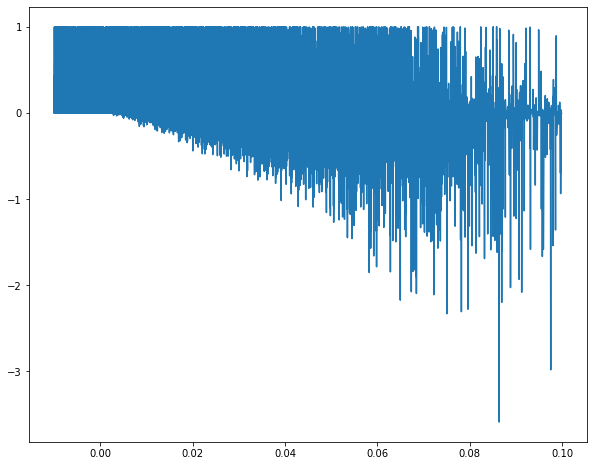

In [25]:
plt.figure(figsize = (10,8))
plt.plot(grille_param["Mu"],grille_param["PS_model_price"])

# RESEAU DE NEURONES

normalise le dataset

In [27]:
grille_param.describe()

,Maturite,Strike,Tenor,Sigma,Lambda,Mu,ZC_model_price,PS_model_price
count,102362.000000,102362.000000,102362.000000,102362.000000,102362.000000,102362.000000,102362.000000,102362.000000
mean,5.488694,0.005255,5.426496,0.003387,0.077529,0.020193,0.983326,0.054314
std,6.787806,0.002881,6.750656,0.002167,0.051364,0.021145,0.080512,0.179628
min,0.083333,0.000500,0.083333,0.000100,0.000101,-0.010000,0.260526,-3.588344
25%,0.500000,0.003000,0.500000,0.001636,0.034443,0.003246,1.000308,0.004952
50%,2.000000,0.005500,1.000000,0.003081,0.070429,0.016545,1.001735,0.016669
75%,10.000000,0.008000,10.000000,0.004823,0.114582,0.033290,1.003978,0.050785
max,20.000000,0.010000,20.000000,0.009998,0.199994,0.099917,1.201441,1.004983


In [30]:
#maturite_normalisation=20
#strike_normalisation=0.010000
#tenor_normalisation=20.0000
#sigma_normalisation=0.010000
#lambda_normalisation=0.19998
#mu_normalisation=0.099989

grille_norm=grille_param.copy()

#grille_norm["Maturite"]=grille_param["Maturite"]/maturite_normalisation
#grille_norm["Strike"]=grille_param["Strike"]/strike_normalisation
#grille_norm["Tenor"]=grille_param["Tenor"]/tenor_normalisation
#grille_norm["Sigma"]=grille_param["Sigma"]/sigma_normalisation
#grille_norm["Lambda"]=grille_param["Lambda"]/lambda_normalisation
#grille_norm["Mu"]=grille_param["Mu"]/mu_normalisation

In [31]:
grille_norm.describe()

,Maturite,Strike,Tenor,Sigma,Lambda,Mu,ZC_model_price,PS_model_price
count,102362.000000,102362.000000,102362.000000,102362.000000,102362.000000,102362.000000,102362.000000,102362.000000
mean,5.488694,0.005255,5.426496,0.003387,0.077529,0.020193,0.983326,0.054314
std,6.787806,0.002881,6.750656,0.002167,0.051364,0.021145,0.080512,0.179628
min,0.083333,0.000500,0.083333,0.000100,0.000101,-0.010000,0.260526,-3.588344
25%,0.500000,0.003000,0.500000,0.001636,0.034443,0.003246,1.000308,0.004952
50%,2.000000,0.005500,1.000000,0.003081,0.070429,0.016545,1.001735,0.016669
75%,10.000000,0.008000,10.000000,0.004823,0.114582,0.033290,1.003978,0.050785
max,20.000000,0.010000,20.000000,0.009998,0.199994,0.099917,1.201441,1.004983


In [32]:
data_sigmabachelier.describe()

,Maturite,Strike,Tenor,Sigma,Swaption_market_price
count,228.000000,2.280000e+02,228.000000,228.00000,228.000000
mean,8.346491,2.500000e-03,11.166667,58.77864,0.024160
std,8.467406,5.215621e-18,9.156415,6.16225,0.022865
min,0.083333,2.500000e-03,1.000000,29.21000,-0.002470
25%,1.000000,2.500000e-03,3.750000,54.08750,0.005552
50%,6.000000,2.500000e-03,8.500000,60.11500,0.017325
75%,12.000000,2.500000e-03,16.250000,63.65000,0.040496
max,30.000000,2.500000e-03,30.000000,72.68000,0.079670


à partir de zero coupons

In [42]:
Y=grille_norm["ZC_model_price"]
X=grille_norm.drop(['ZC_model_price','Tenor','Strike',"PS_model_price"], axis=1)
trainX,validX,trainY,validY =  train_test_split(X,Y,train_size=0.75,test_size =0.25,shuffle=True,random_state=0)

In [46]:
# Create a Sequential
model_ZC = Sequential()
# Add a Dense layer with 6 neurons, with relu as activation function and input dimension equal to the number of features
dense_layer1 = Dense(units=8, activation='relu',input_shape=(4,))
model_ZC.add(dense_layer1)


# Add a Dense layer with 3 neurons, with relu as activation function
dense_layer2 = Dense(units=12, activation='relu')
model_ZC.add(dense_layer2)


# Add a Dense layer with 32 neurons, with relu as activation function
dense_layer2_bis = Dense(units=18, activation='sigmoid')
model_ZC.add(dense_layer2_bis)

# To produce the output Add a Dense layer with 1 neurons, with sigmoid as activation function
dense_layer3 = Dense(units=1, activation='elu')
model_ZC.add(dense_layer3)
model_ZC.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 8)                 40        
                                                                 
 dense_9 (Dense)             (None, 12)                108       
                                                                 
 dense_10 (Dense)            (None, 18)                234       
                                                                 
 dense_11 (Dense)            (None, 1)                 19        
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [47]:
model_ZC.compile(optimizer='Adam',
              loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [48]:
batch_size = 200
epochs = 100
history_ZC = model_ZC.fit(trainX, trainY, epochs=epochs, batch_size=batch_size,validation_data=(validX,validY))

Epoch 1/100
384/384 [==============================] - 3s 7ms/step - loss: 0.2295 - rmse: 0.4790 - val_loss: 0.0057 - val_rmse: 0.0756
Epoch 2/100
384/384 [==============================] - 3s 7ms/step - loss: 0.0056 - rmse: 0.0746 - val_loss: 0.0050 - val_rmse: 0.0705
Epoch 3/100
384/384 [==============================] - 3s 9ms/step - loss: 0.0049 - rmse: 0.0701 - val_loss: 0.0044 - val_rmse: 0.0661
Epoch 4/100
384/384 [==============================] - 3s 8ms/step - loss: 0.0040 - rmse: 0.0635 - val_loss: 0.0033 - val_rmse: 0.0573
Epoch 5/100
384/384 [==============================] - 3s 8ms/step - loss: 0.0027 - rmse: 0.0520 - val_loss: 0.0020 - val_rmse: 0.0445
Epoch 6/100
384/384 [==============================] - 3s 7ms/step - loss: 0.0016 - rmse: 0.0396 - val_loss: 0.0014 - val_rmse: 0.0380
Epoch 7/100
384/384 [==============================] - 3s 7ms/step - loss: 0.0010 - rmse: 0.0322 - val_loss: 8.8511e-04 - val_rmse: 0.0298
Epoch 8/100
384/384 [==============================

384/384 [==============================] - 3s 7ms/step - loss: 1.1573e-04 - rmse: 0.0108 - val_loss: 1.0087e-04 - val_rmse: 0.0100
Epoch 59/100
384/384 [==============================] - 3s 7ms/step - loss: 1.1637e-04 - rmse: 0.0108 - val_loss: 1.1466e-04 - val_rmse: 0.0107
Epoch 60/100
384/384 [==============================] - 3s 7ms/step - loss: 1.1468e-04 - rmse: 0.0107 - val_loss: 1.6248e-04 - val_rmse: 0.0127
Epoch 61/100
384/384 [==============================] - 3s 7ms/step - loss: 1.1331e-04 - rmse: 0.0106 - val_loss: 1.0926e-04 - val_rmse: 0.0105
Epoch 62/100
384/384 [==============================] - 2s 6ms/step - loss: 1.1825e-04 - rmse: 0.0109 - val_loss: 1.2754e-04 - val_rmse: 0.0113
Epoch 63/100
384/384 [==============================] - 3s 7ms/step - loss: 1.2047e-04 - rmse: 0.0110 - val_loss: 1.1614e-04 - val_rmse: 0.0108
Epoch 64/100
384/384 [==============================] - 2s 6ms/step - loss: 1.1678e-04 - rmse: 0.0108 - val_loss: 1.0166e-04 - val_rmse: 0.0101
Epoch

In [50]:
model_ZC.evaluate(validX, validY)

800/800 [==============================] - 3s 3ms/step - loss: 1.0423e-04 - rmse: 0.0102


[0.00010423267667647451, 0.010209441184997559]

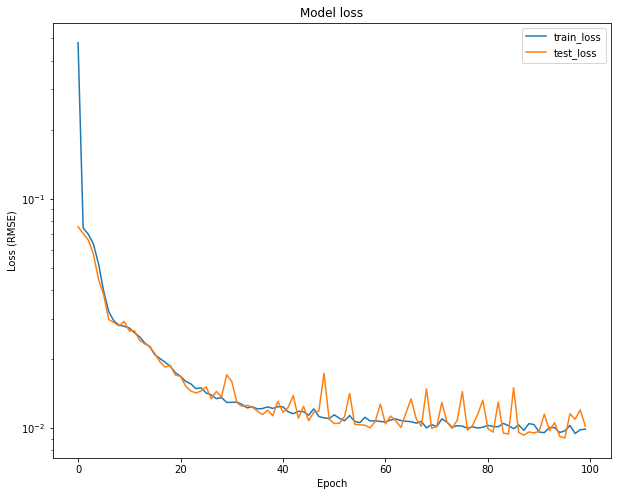

In [58]:
plt.figure(figsize = (10,8))
plot_history(history_ZC)

à partir des prix simulés

In [68]:
Y=grille_norm["PS_model_price"]
X=grille_norm.drop(['ZC_model_price',"PS_model_price"], axis=1)
trainX,validX,trainY,validY =  train_test_split(X,Y,train_size=0.75,test_size =0.25,shuffle=True,random_state=0)

In [69]:
# Create a Sequential
model_Price = Sequential()
# Add a Dense layer with 6 neurons, with relu as activation function and input dimension equal to the number of features
dense_layer1 = Dense(units=8, activation='relu',input_shape=(6,))
model_Price.add(dense_layer1)


# Add a Dense layer with 3 neurons, with relu as activation function
dense_layer2 = Dense(units=12, activation='relu')
model_Price.add(dense_layer2)


# Add a Dense layer with 32 neurons, with relu as activation function
dense_layer2_bis = Dense(units=18, activation='sigmoid')
model_Price.add(dense_layer2_bis)

# Add a Dense layer with 32 neurons, with relu as activation function
dense_layer2_bis2 = Dense(units=32, activation='tanh')
model_Price.add(dense_layer2_bis2)

dense_layer2_bis23 = Dense(units=32, activation='relu')
model_Price.add(dense_layer2_bis23)



# To produce the output Add a Dense layer with 1 neurons, with sigmoid as activation function
dense_layer3 = Dense(units=1, activation='elu')
model_Price.add(dense_layer3)
model_Price.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8)                 56        
                                                                 
 dense_13 (Dense)            (None, 12)                108       
                                                                 
 dense_14 (Dense)            (None, 18)                234       
                                                                 
 dense_15 (Dense)            (None, 32)                608       
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,095
Trainable params: 2,095
Non-traina

In [72]:
model_Price.compile(optimizer='Adam',
              loss="mean_squared_error",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [73]:
batch_size = 100
epochs = 100
history_Price = model_Price.fit(trainX, trainY, epochs=epochs, batch_size=batch_size,validation_data=(validX,validY))

Epoch 1/100
768/768 [==============================] - 6s 7ms/step - loss: 0.0294 - rmse: 0.1714 - val_loss: 0.0226 - val_rmse: 0.1505
Epoch 2/100
768/768 [==============================] - 6s 7ms/step - loss: 0.0201 - rmse: 0.1417 - val_loss: 0.0154 - val_rmse: 0.1239
Epoch 3/100
768/768 [==============================] - 6s 7ms/step - loss: 0.0141 - rmse: 0.1186 - val_loss: 0.0115 - val_rmse: 0.1073
Epoch 4/100
768/768 [==============================] - 6s 7ms/step - loss: 0.0112 - rmse: 0.1058 - val_loss: 0.0087 - val_rmse: 0.0930
Epoch 5/100
768/768 [==============================] - 6s 7ms/step - loss: 0.0098 - rmse: 0.0990 - val_loss: 0.0083 - val_rmse: 0.0911
Epoch 6/100
768/768 [==============================] - 6s 7ms/step - loss: 0.0090 - rmse: 0.0950 - val_loss: 0.0080 - val_rmse: 0.0892
Epoch 7/100
768/768 [==============================] - 6s 7ms/step - loss: 0.0085 - rmse: 0.0923 - val_loss: 0.0087 - val_rmse: 0.0935
Epoch 8/100
768/768 [==============================] - 

768/768 [==============================] - 6s 7ms/step - loss: 0.0029 - rmse: 0.0541 - val_loss: 0.0028 - val_rmse: 0.0524
Epoch 62/100
768/768 [==============================] - 6s 7ms/step - loss: 0.0030 - rmse: 0.0549 - val_loss: 0.0026 - val_rmse: 0.0508
Epoch 63/100
768/768 [==============================] - 6s 7ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0028 - val_rmse: 0.0528
Epoch 64/100
768/768 [==============================] - 6s 7ms/step - loss: 0.0033 - rmse: 0.0578 - val_loss: 0.0037 - val_rmse: 0.0604
Epoch 65/100
768/768 [==============================] - 6s 8ms/step - loss: 0.0028 - rmse: 0.0526 - val_loss: 0.0031 - val_rmse: 0.0556
Epoch 66/100
768/768 [==============================] - 6s 8ms/step - loss: 0.0029 - rmse: 0.0541 - val_loss: 0.0031 - val_rmse: 0.0555
Epoch 67/100
768/768 [==============================] - 5s 7ms/step - loss: 0.0028 - rmse: 0.0526 - val_loss: 0.0032 - val_rmse: 0.0567
Epoch 68/100
768/768 [==============================] - 6s 8m

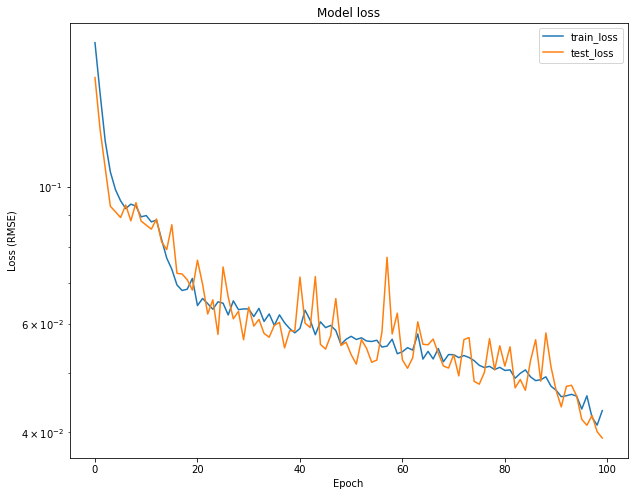

In [75]:
plt.figure(figsize = (10,8))
plot_history(history_Price)

# Partie 2 : use market prices to calibrate the paramters

In [59]:
def rmse_nn_function_ZC(param_to_optimize):
    X = grille_market[['Maturite']].copy() 
    X["Sigma"] = param_to_optimize[0]#param_to_optimize[0]  # car pas de sigma
    X["Lambda"] = param_to_optimize[1]
    X["Mu"] = param_to_optimize[2]
    X["ZC_price_predicted"] = model_ZC.predict(X)
    SE = (grille_market["ZC_market_price"] - X["ZC_price_predicted"])**2
    return np.sqrt(SE.mean())



In [95]:
minimize(rmse_nn_function_ZC, [0.001,0.025,0.01], method='Nelder-Mead', tol=1e-3, options = {'maxiter' : 300, 'disp' : True}, bounds = ((0.0001,0.01),(0.01,0.15),(-0.01,0.1))) 

Optimization terminated successfully.
         Current function value: 0.003649
         Iterations: 14
         Function evaluations: 28


 final_simplex: (array([[0.00081832, 0.03550997, 0.01088341],
       [0.00081667, 0.03597222, 0.01038889],
       [0.00082942, 0.03505099, 0.01082998],
       [0.0008    , 0.03458333, 0.01133333]]), array([0.00364864, 0.00365626, 0.00369286, 0.00371064]))
           fun: 0.003648642098081877
       message: 'Optimization terminated successfully.'
          nfev: 28
           nit: 14
        status: 0
       success: True
             x: array([0.00081832, 0.03550997, 0.01088341])

calibration avec les fonctions swaptions, attention, à utiliser si on calibre avec un modèle train

In [86]:
def rmse_nn_function_Price(param_to_optimize):
    X = data_sigmabachelier[['Maturite',"Strike","Tenor"]].copy() 
    X["Sigma"] = param_to_optimize[0]
    X["Lambda"] = param_to_optimize[1]
    X["Mu"] = param_to_optimize[2]
    X["Swaption_price_predicted"] = model_Price.predict(X)
    SE = (data_sigmabachelier["Swaption_market_price"] - X["Swaption_price_predicted"])**2
    return np.sqrt(SE.mean())
                     

In [98]:
minimize(rmse_nn_function_Price, [0.004,0.075,0.02], method='Nelder-Mead', tol=1e-3, options = {'maxiter' : 1000, 'disp' : True}, bounds = ((0.0001,0.01),(0.01,0.15),(-0.01,0.1))) 


Optimization terminated successfully.
         Current function value: 0.028147
         Iterations: 30
         Function evaluations: 53


 final_simplex: (array([[ 0.01      ,  0.15      , -0.00675954],
       [ 0.01      ,  0.15      , -0.00639949],
       [ 0.01      ,  0.15      , -0.00609944],
       [ 0.01      ,  0.15      , -0.00774968]]), array([0.02814688, 0.02815417, 0.02816996, 0.02817372]))
           fun: 0.028146876492718232
       message: 'Optimization terminated successfully.'
          nfev: 53
           nit: 30
        status: 0
       success: True
             x: array([ 0.01      ,  0.15      , -0.00675954])

### Recherche par gradient sotchastique par réseau de neurones

In [76]:
grille_market["Sigma"] = 1
grille_market["Lambda"] = 1
grille_market["Mu"] = 1
grille_market

,ZC_market_price,Maturite,Tenor,Strike,Sigma,Lambda,Mu
2,1.000409,0.083333,0.500000,0.0005,1,1,1
14,1.000409,0.083333,1.000000,0.0010,1,1,1
21,1.000409,0.083333,0.250000,0.0015,1,1,1
23,1.000409,0.083333,0.750000,0.0015,1,1,1
25,1.000409,0.083333,2.000000,0.0015,1,1,1
...,...,...,...,...,...,...,...
401980,0.968873,20.000000,0.083333,0.0095,1,1,1
401981,0.968873,20.000000,0.250000,0.0095,1,1,1
401985,0.968873,20.000000,2.000000,0.0095,1,1,1
401996,0.968873,20.000000,5.000000,0.0100,1,1,1


In [77]:
Y=grille_market["ZC_market_price"].to_numpy()
X=grille_market.drop(['ZC_market_price'], axis=1)

Création du réseau de neuronnes qui recherche de manière stochastique les paramètres

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                            

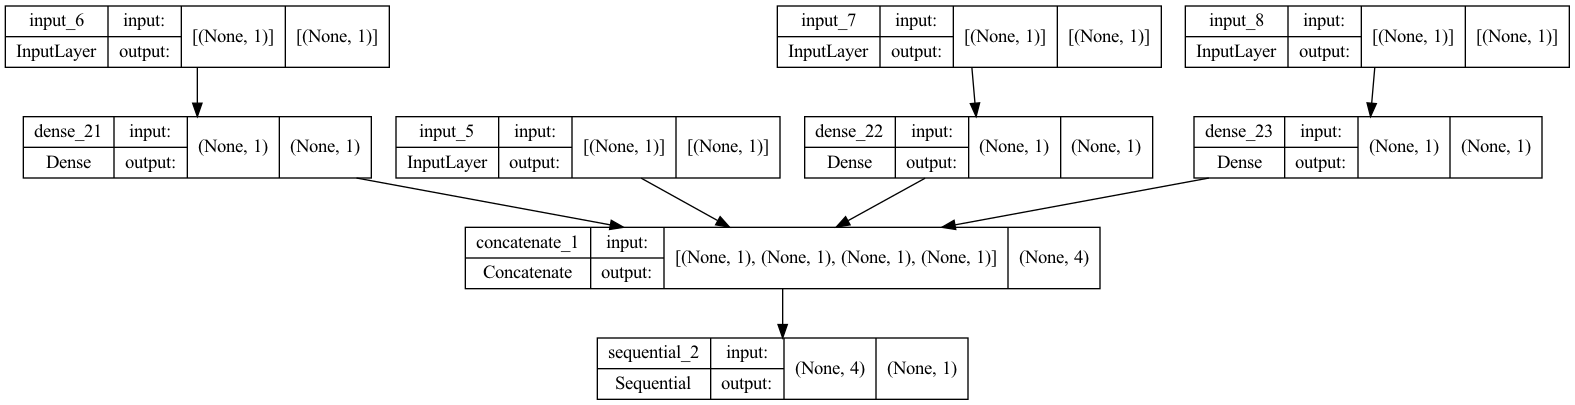

In [82]:
x1 = tf.keras.Input(shape=(1,))
x2 = tf.keras.Input(shape=(1,))
x3 = tf.keras.Input(shape=(1,))
x4 = tf.keras.Input(shape=(1,))

x2_ = tf.keras.layers.Dense(1)(x2)
x3_ = tf.keras.layers.Dense(1)(x3)
x4_ = tf.keras.layers.Dense(1)(x4)


merged = tf.keras.layers.concatenate([x1, x2_,x3_,x4_])

model_ZC.trainable = False  ##permet de freeze la fonction de pricing des ZC

outputs = model_ZC(merged)

model_parameters = tf.keras.Model(inputs=[x1,x2,x3,x4], outputs=outputs)

model_parameters.compile(optimizer='Adam',
              loss="mean_squared_error")

model_parameters.summary()

plot_model(model_parameters, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Recherche stochastique

In [83]:
batch_size = 100
epochs = 20
history = model_parameters.fit([X.Maturite.to_numpy(),X.Sigma.to_numpy(),X.Lambda.to_numpy(),X.Mu.to_numpy()], Y, epochs=epochs, batch_size=batch_size)

Epoch 1/20
1024/1024 [==============================] - 6s 6ms/step - loss: 0.0851
Epoch 2/20
1024/1024 [==============================] - 6s 5ms/step - loss: 0.0471
Epoch 3/20
1024/1024 [==============================] - 6s 5ms/step - loss: 0.0283
Epoch 4/20
1024/1024 [==============================] - 6s 6ms/step - loss: 0.0186
Epoch 5/20
1024/1024 [==============================] - 6s 6ms/step - loss: 0.0132
Epoch 6/20
1024/1024 [==============================] - 6s 5ms/step - loss: 0.0098
Epoch 7/20
1024/1024 [==============================] - 6s 5ms/step - loss: 0.0076
Epoch 8/20
1024/1024 [==============================] - 6s 5ms/step - loss: 0.0060
Epoch 9/20
1024/1024 [==============================] - 6s 5ms/step - loss: 0.0047
Epoch 10/20
1024/1024 [==============================] - 6s 5ms/step - loss: 0.0039
Epoch 11/20
1024/1024 [==============================] - 6s 5ms/step - loss: 0.0033
Epoch 12/20
1024/1024 [==============================] - 6s 6ms/step - loss: 0.0029
E

Affichage de nos résultats de la calibration

In [85]:
def resultatCalibration(model_parameters):
    resultat=[]
    for i in range(12):
        try:
            resultat.append(model_parameters.layers[i].get_weights()[0][0][0]+model_parameters.layers[i].get_weights()[1][0])
        except:
            pass
    sigma=resultat[0]
    lambd=resultat[1]
    mu=resultat[2]
    print("Notre modèle nous donne :")
    print("Sigma = ",sigma)
    print("Lambda = ",lambd)
    print("Mu = ",mu)
    return sigma,lambd,mu

resultatCalibration(model_parameters)

Notre modèle nous donne :
Sigma =  4.265031
Lambda =  0.18004316
Mu =  15.627205


(4.265031, 0.18004316, 15.627205)